# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
filename = 'hoasa-lc-coreset'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [10]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [11]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [12]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [13]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [14]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [15]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [16]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [17]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [18]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    accelerator.wait_for_everyone()
    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-model-{percentage}')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [19]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [20]:
def combined_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)
                
    accelerator.wait_for_everyone()
    if not final_cp:
        aspect_dataset = AspectDetectionDataset(
            X_pool, 
            [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
            label_mapping, 
            tokenizer, 
            max_length=sequence_length
        )
        aspect_loader = DataLoader(
            aspect_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )

        start_time = time.time()

        lc_indices = least_confidence_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")

        coreset_indices = coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, device, target_samples)
        coreset_indices = [remaining_indices[i] for i in coreset_indices]
        accelerator.print(f"Got {len(coreset_indices)} samples from coreset")

        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(lc_indices).union(set(coreset_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'ac': [y_train[i][0] for i in temp],
                    'air_panas': [y_train[i][1] for i in temp],
                    'bau': [y_train[i][2] for i in temp],
                    'general': [y_train[i][3] for i in temp],
                    'kebersihan': [y_train[i][4] for i in temp],
                    'linen': [y_train[i][5] for i in temp],
                    'service': [y_train[i][6] for i in temp],
                    'sunrise_meal': [y_train[i][7] for i in temp],
                    'tv': [y_train[i][8] for i in temp],
                    'wifi': [y_train[i][9] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

In [21]:
def least_confidence_sampling(aspect_model, sentiment_model, aspect_loader, device, target_samples):
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            aspect_outputs[batch['ori_indices'][i].item()] = np.max(preds[i].cpu().numpy())
            
            for j in range(len(preds[i])):
                if int(preds[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])
    
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        with torch.no_grad():
            outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            preds = torch.sigmoid(outputs.logits)

        for i in range(len(preds)):
            ori_index = batch['ori_indices'][i].item()
            if ori_index in sentiment_outputs.keys():
                max_pred = np.max(preds[i].cpu().numpy())
                sentiment_outputs[ori_index] = max_pred if max_pred > sentiment_outputs[ori_index] else sentiment_outputs[ori_index]
            else:
                sentiment_outputs[ori_index] = np.max(preds[i].cpu().numpy())

    aspect_outputs = dict(sorted(aspect_outputs.items()))

    # accelerator.print(aspect_outputs)
    for key, val in sentiment_outputs.items():
        aspect_outputs[key] = 1 - ((val + aspect_outputs[key]) / 2)

    # accelerator.print(aspect_outputs)
    uncertainties = np.array(list(aspect_outputs.values()))
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:target_samples]

    return least_confident_indices

In [22]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, device, target_samples):
    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)

    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []
    
    aspect_outputs = dict(sorted(aspect_outputs.items()))

    if len(data) > 0:
        for key, val in sentiment_outputs.items():
            aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

    embeddings = np.array(list(aspect_outputs.values()))
    distance_matrix = pairwise_distances(embeddings)
    selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

    # Calculate the minimum distance from selected points to all other points
    min_distances = distance_matrix[selected_indices]

    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set

    return sorted_dist[:target_samples]

# MAIN LOOP

In [23]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    # aspect_model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')
    # sentiment_model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1')
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-model-{percentage}')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [24]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.7995, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4747, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.425, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8064, F1 Micro: 0.8916, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4121, Accuracy: 0.8101, F1 Micro: 0.8933, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3857, Accuracy: 0.8177, F1 Micro: 0.8971, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3725, Accuracy: 0.8321, F1 Micro: 0.9044, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5503, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3898, Accuracy: 0.6878, F1 Micro: 0.6878, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3441, Accuracy: 0.7488, F1 Micro: 0.7488, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2402, Accuracy: 0.7756, F1 Micro: 0.7756, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.7512, F1 Micro: 0.7512, F1 Macro: 0.6996
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5567, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4861, Accuracy: 0.8028, F1 Micro: 0.8903, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4614, Accuracy: 0.8217, F1 Micro: 0.8985, F1 Macro: 0.8921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4046, Accuracy: 0.8448, F1 Micro: 0.9105, F1 Macro: 0.9054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3779, Accuracy: 0.8766, F1 Micro: 0.9276, F1 Macro: 0.9236
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3154, Accuracy: 0.8943, F1 Micro: 0.9375, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2717, Accuracy: 0.9092, F1 Micro: 0.9458, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.238, Accuracy: 0.9179, F1 Micro: 0.9504, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.7296, F1 Micro: 0.7296, F1 Macro: 0.4218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4452, Accuracy: 0.8145, F1 Micro: 0.8145, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3572, Accuracy: 0.8462, F1 Micro: 0.8462, F1 Macro: 0.7955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2621, Accuracy: 0.8575, F1 Micro: 0.8575, F1 Macro: 0.8105
Epoch 5/10, Train Loss: 0.2384, Accuracy: 0.8484, F1 Micro: 0.8484, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1915, Accuracy: 0.871, F1 Micro: 0.871, F1 Macro: 0.8275
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2081, Accuracy: 0.8857, F1 Micro: 0.8857, F1 Macro: 0.847
Epoch 8/10, Train Loss: 0.1392, Accuracy: 0.8801, F1 Micro: 0.8801, F1 Macro: 0.8361
Epoch 9/10, Train Loss: 0.1441, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8315
Epoch 10/10, Train Loss: 0.1089, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5212, Accuracy: 0.8009, F1 Micro: 0.8894, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4483, Accuracy: 0.8174, F1 Micro: 0.8968, F1 Macro: 0.8909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4087, Accuracy: 0.8498, F1 Micro: 0.9137, F1 Macro: 0.9091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3409, Accuracy: 0.8915, F1 Micro: 0.9357, F1 Macro: 0.9323
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2842, Accuracy: 0.9139, F1 Micro: 0.9481, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2362, Accuracy: 0.9264, F1 Micro: 0.9554, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1979, Accuracy: 0.9319, F1 Micro: 0.9587, F1 Macro: 0.956
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1719, Accuracy: 0.9363, F1 Micro: 0.9613, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5132, Accuracy: 0.8092, F1 Micro: 0.8092, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3633, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.7901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3165, Accuracy: 0.8644, F1 Micro: 0.8644, F1 Macro: 0.8077
Epoch 4/10, Train Loss: 0.2283, Accuracy: 0.8603, F1 Micro: 0.8603, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1906, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8134
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.879, F1 Micro: 0.879, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8376
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8599
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8518
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5178, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4543, Accuracy: 0.8344, F1 Micro: 0.9058, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3849, Accuracy: 0.8885, F1 Micro: 0.9337, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3147, Accuracy: 0.9116, F1 Micro: 0.9472, F1 Macro: 0.9445
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2524, Accuracy: 0.9304, F1 Micro: 0.9577, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2084, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1882, Accuracy: 0.945, F1 Micro: 0.9664, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.158, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9651
Epoch 9/10, Train Loss: 0.139, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5163, Accuracy: 0.8306, F1 Micro: 0.8306, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3492, Accuracy: 0.8498, F1 Micro: 0.8498, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.876, F1 Micro: 0.876, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.8911, F1 Micro: 0.8911, F1 Macro: 0.8476
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.141, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8682
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8467
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.8982, F1 Micro: 0.8982, F1 Macro: 0.8569
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8638
Epoch 10/10, Train Loss: 0.0246, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5025, Accuracy: 0.8024, F1 Micro: 0.8902, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4351, Accuracy: 0.8616, F1 Micro: 0.9196, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3549, Accuracy: 0.9033, F1 Micro: 0.9422, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2743, Accuracy: 0.9311, F1 Micro: 0.958, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2205, Accuracy: 0.9387, F1 Micro: 0.9627, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1828, Accuracy: 0.9441, F1 Micro: 0.9659, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1564, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1385, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4812, Accuracy: 0.8153, F1 Micro: 0.8153, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3332, Accuracy: 0.8674, F1 Micro: 0.8674, F1 Macro: 0.819
Epoch 3/10, Train Loss: 0.2624, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.8124
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1705, Accuracy: 0.8788, F1 Micro: 0.8788, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1414, Accuracy: 0.8797, F1 Micro: 0.8797, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8582
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.8807, F1 Micro: 0.8807, F1 Macro: 0.8349
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8615
Epoch 10/10, Train Loss: 0.0401, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5076, Accuracy: 0.808, F1 Micro: 0.8926, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4215, Accuracy: 0.8687, F1 Micro: 0.9239, F1 Macro: 0.9205
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3286, Accuracy: 0.9182, F1 Micro: 0.9507, F1 Macro: 0.9478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2571, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2071, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1742, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1517, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.9672
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9502, F1 Micro: 0.9693, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1152, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.8315, F1 Micro: 0.8315, F1 Macro: 0.7861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3107, Accuracy: 0.8577, F1 Micro: 0.8577, F1 Macro: 0.8112
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2197, Accuracy: 0.8848, F1 Micro: 0.8848, F1 Macro: 0.853
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8645
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8696
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8646
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.859
Epoch 9/10, Train Loss: 0.0368, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8617
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0226, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5066, Accuracy: 0.8057, F1 Micro: 0.8918, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3946, Accuracy: 0.8894, F1 Micro: 0.9347, F1 Macro: 0.9316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2994, Accuracy: 0.9283, F1 Micro: 0.9567, F1 Macro: 0.9543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.228, Accuracy: 0.9418, F1 Micro: 0.9646, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1909, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1325, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.972
Epoch 8/10, Train Loss: 0.119, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.972
Epoch 9/10, Train Loss: 0.1032, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.436, Accuracy: 0.8414, F1 Micro: 0.8414, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2769, Accuracy: 0.8832, F1 Micro: 0.8832, F1 Macro: 0.8455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2161, Accuracy: 0.8879, F1 Micro: 0.8879, F1 Macro: 0.8461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.882
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8706
Epoch 7/10, Train Loss: 0.0662, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.879
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4948, Accuracy: 0.8286, F1 Micro: 0.9029, F1 Macro: 0.898
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3833, Accuracy: 0.895, F1 Micro: 0.9379, F1 Macro: 0.9352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2747, Accuracy: 0.9385, F1 Micro: 0.9623, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2131, Accuracy: 0.9439, F1 Micro: 0.9658, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1764, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1509, Accuracy: 0.9566, F1 Micro: 0.9731, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1248, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1086, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.0912, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4354, Accuracy: 0.8553, F1 Micro: 0.8553, F1 Macro: 0.8188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8423
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1809, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1515, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8839
Epoch 5/10, Train Loss: 0.1024, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8709
Epoch 6/10, Train Loss: 0.0779, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8826
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8919
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8786
Epoch 10/10, Train Loss: 0.0392, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4862, Accuracy: 0.8264, F1 Micro: 0.9013, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3707, Accuracy: 0.9076, F1 Micro: 0.945, F1 Macro: 0.9429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2581, Accuracy: 0.9332, F1 Micro: 0.9595, F1 Macro: 0.9566
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1986, Accuracy: 0.947, F1 Micro: 0.9675, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9517, F1 Micro: 0.9704, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1373, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1017, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.859, F1 Micro: 0.859, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.8655, F1 Micro: 0.8655, F1 Macro: 0.8171
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1972, Accuracy: 0.8908, F1 Micro: 0.8908, F1 Macro: 0.8627
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.8833, F1 Micro: 0.8833, F1 Macro: 0.8431
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0933, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8783
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.8964, F1 Micro: 0.8964, F1 Macro: 0.8621
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8791
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.8945, F1 Micro: 0.8945, F1 Macro: 0.8616
Epoch 9/10, Train Loss: 0.0482, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8685
Epoch 10/10, Train Loss: 0.0298, Accuracy: 0.9048, F1 Micro: 0.9048, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.487, Accuracy: 0.8399, F1 Micro: 0.9079, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3526, Accuracy: 0.9139, F1 Micro: 0.9483, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2444, Accuracy: 0.934, F1 Micro: 0.9597, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1975, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.163, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1341, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1176, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Epoch 8/10, Train Loss: 0.0989, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0859, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8338, F1 Micro: 0.8338, F1 Macro: 0.7514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.8886, F1 Micro: 0.8886, F1 Macro: 0.8513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.188, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8753
Epoch 7/10, Train Loss: 0.0455, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0279, Accuracy: 0.9099, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4772, Accuracy: 0.8481, F1 Micro: 0.9125, F1 Macro: 0.9082
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3324, Accuracy: 0.9144, F1 Micro: 0.9489, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2352, Accuracy: 0.9392, F1 Micro: 0.9631, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9698
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9552, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9723
Epoch 8/10, Train Loss: 0.0929, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4027, Accuracy: 0.8558, F1 Micro: 0.8558, F1 Macro: 0.8078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2271, Accuracy: 0.8832, F1 Micro: 0.8832, F1 Macro: 0.8486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8513
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1227, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8666
Epoch 5/10, Train Loss: 0.0836, Accuracy: 0.8923, F1 Micro: 0.8923, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0652, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8678
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.8951, F1 Micro: 0.8951, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8749
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8674
Epoch 10/10, Train Loss: 0.0223, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4768, Accuracy: 0.847, F1 Micro: 0.911, F1 Macro: 0.9037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3335, Accuracy: 0.9259, F1 Micro: 0.9552, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2331, Accuracy: 0.9431, F1 Micro: 0.965, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1871, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1494, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1075, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0908, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8669, F1 Micro: 0.8669, F1 Macro: 0.8177
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1091, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8738
Epoch 5/10, Train Loss: 0.0786, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8737
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8636
Epoch 7/10, Train Loss: 0.049, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8701
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8846
Epoch 9/10, Train Loss: 0.0216, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8824
Epoch 10/10, Train Loss: 0.0244, Accuracy: 0.9076, F1 Micro: 0.9076, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4682, Accuracy: 0.8587, F1 Micro: 0.9181, F1 Macro: 0.914
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3193, Accuracy: 0.9288, F1 Micro: 0.9569, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.224, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Epoch 7/10, Train Loss: 0.1054, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3815, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2304, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1515, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8801
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0654, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8814
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8807
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8605
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8866
Epoch 10/10, Train Loss: 0.0314, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.8642, F1 Micro: 0.9207, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.31, Accuracy: 0.9304, F1 Micro: 0.9579, F1 Macro: 0.9555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1059, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0717, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3852, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2414, Accuracy: 0.8783, F1 Micro: 0.8783, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1579, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1018, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8827
Epoch 5/10, Train Loss: 0.0772, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8766
Epoch 6/10, Train Loss: 0.0643, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.031, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0195, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8885
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4598, Accuracy: 0.8691, F1 Micro: 0.9235, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3045, Accuracy: 0.9318, F1 Micro: 0.9586, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2117, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9741
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9718
Epoch 8/10, Train Loss: 0.0828, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9727
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3714, Accuracy: 0.8557, F1 Micro: 0.8557, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1944, Accuracy: 0.886, F1 Micro: 0.886, F1 Macro: 0.8585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1075, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8742
Epoch 5/10, Train Loss: 0.0765, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8715
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8677
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8691
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8664
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8694
Epoch 10/10, Train Loss: 0.0195, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8721

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4615, Accuracy: 0.8653, F1 Micro: 0.9209, F1 Macro: 0.9152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.288, Accuracy: 0.9316, F1 Micro: 0.9585, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.208, Accuracy: 0.9439, F1 Micro: 0.9658, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9727
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3664, Accuracy: 0.8588, F1 Micro: 0.8588, F1 Macro: 0.8239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8707
Epoch 3/10, Train Loss: 0.1623, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0791, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8758
Epoch 6/10, Train Loss: 0.063, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8723
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8592
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8757
Epoch 9/10, Train Loss: 0.0293, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8714
Epoch 10/10, Train Loss: 0.027, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4635, Accuracy: 0.8717, F1 Micro: 0.9248, F1 Macro: 0.9204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2928, Accuracy: 0.9299, F1 Micro: 0.9576, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2047, Accuracy: 0.946, F1 Micro: 0.9669, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.367, Accuracy: 0.867, F1 Micro: 0.867, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1508, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1032, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8828
Epoch 5/10, Train Loss: 0.078, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8823
Epoch 6/10, Train Loss: 0.0688, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8782
Epoch 7/10, Train Loss: 0.0392, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8749
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8822
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8696, F1 Micro: 0.924, F1 Macro: 0.9199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2845, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9505, F1 Micro: 0.9695, F1 Macro: 0.9669
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1305, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9729
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Epoch 8/10, Train Loss: 0.0755, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0636, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9749
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8426, F1 Micro: 0.8426, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2129, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1095, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8817
Epoch 5/10, Train Loss: 0.0714, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8802
Epoch 6/10, Train Loss: 0.0672, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8816
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0402, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8837
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8829
Epoch 10/10, Train Loss: 0.0192, Accuracy: 0.9045, F1 Micro: 0.9045, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4582, Accuracy: 0.8764, F1 Micro: 0.9271, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2803, Accuracy: 0.9316, F1 Micro: 0.9586, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1578, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1294, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1071, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1321, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0976, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8847
Epoch 5/10, Train Loss: 0.0566, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8696
Epoch 6/10, Train Loss: 0.0603, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8803
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8887
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0254, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8949
Epoch 10/10, Train Loss: 0.0233, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4518, Accuracy: 0.8799, F1 Micro: 0.9296, F1 Macro: 0.9264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.9352, F1 Micro: 0.9605, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3594, Accuracy: 0.8505, F1 Micro: 0.8505, F1 Macro: 0.7851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2215, Accuracy: 0.8917, F1 Micro: 0.8917, F1 Macro: 0.8529
Epoch 3/10, Train Loss: 0.1405, Accuracy: 0.8881, F1 Micro: 0.8881, F1 Macro: 0.8472
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1037, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8854
Epoch 5/10, Train Loss: 0.0703, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.886
Epoch 6/10, Train Loss: 0.0463, Accuracy: 0.8963, F1 Micro: 0.8963, F1 Macro: 0.8668
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8775
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8771
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8782
Epoch 10/10, Train Loss: 0.0094, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.877

Sentiment analysis accuracy: 0.9138, F1 Micro: 0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.447, Accuracy: 0.8792, F1 Micro: 0.9291, F1 Macro: 0.9252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.9368, F1 Micro: 0.9614, F1 Macro: 0.9587
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1959, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3486, Accuracy: 0.8663, F1 Micro: 0.8663, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1932, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8652
Epoch 3/10, Train Loss: 0.1574, Accuracy: 0.8874, F1 Micro: 0.8874, F1 Macro: 0.8454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.109, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0718, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0615, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0503, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.891
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8837
Epoch 9/10, Train Loss: 0.0214, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8842
Epoch 10/10, Train Loss: 0.0324, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4467, Accuracy: 0.8771, F1 Micro: 0.9281, F1 Macro: 0.9246
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9359, F1 Micro: 0.9611, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9737
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0728, Accuracy: 0.967, F1 Micro: 0.9795, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0605, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3507, Accuracy: 0.8634, F1 Micro: 0.8634, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2227, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1471, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1076, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0747, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8868
Epoch 6/10, Train Loss: 0.0634, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8825
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8921
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8857
Epoch 10/10, Train Loss: 0.0268, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8847, F1 Micro: 0.9323, F1 Macro: 0.9292
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1859, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9573, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.344, Accuracy: 0.8761, F1 Micro: 0.8761, F1 Macro: 0.8384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2005, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1269, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.886
Epoch 4/10, Train Loss: 0.0913, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0528, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0486, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8881
Epoch 7/10, Train Loss: 0.0427, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.022, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8908
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8862
Epoch 10/10, Train Loss: 0.0286, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4323, Accuracy: 0.8814, F1 Micro: 0.9301, F1 Macro: 0.9262
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2573, Accuracy: 0.9389, F1 Micro: 0.9629, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0967, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.9637, F1 Micro: 0.9773, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3699, Accuracy: 0.8582, F1 Micro: 0.8582, F1 Macro: 0.805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2026, Accuracy: 0.897, F1 Micro: 0.897, F1 Macro: 0.8647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1312, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8756
Epoch 4/10, Train Loss: 0.0946, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0604, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8871
Epoch 7/10, Train Loss: 0.042, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8695
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8852
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8725
Epoch 10/10, Train Loss: 0.0208, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4312, Accuracy: 0.8936, F1 Micro: 0.937, F1 Macro: 0.934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.9377, F1 Micro: 0.962, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1786, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1377, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.977
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3617, Accuracy: 0.8759, F1 Micro: 0.8759, F1 Macro: 0.8367
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2011, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1119, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0898, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.891
Epoch 5/10, Train Loss: 0.0588, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8872
Epoch 6/10, Train Loss: 0.0557, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8912
Epoch 7/10, Train Loss: 0.0346, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8822
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0171, Accuracy: 0.9228, F1 Micro: 0.9228, F1 Macro: 0.8995
Epoch 10/10, Train Loss: 0.0247, Accuracy: 0.921, F1 Micro: 0.921, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4259, Accuracy: 0.8917, F1 Micro: 0.936, F1 Macro: 0.9333
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2497, Accuracy: 0.9406, F1 Micro: 0.9637, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1358, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3316, Accuracy: 0.8757, F1 Micro: 0.8757, F1 Macro: 0.8372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1848, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.133, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0948, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8885
Epoch 5/10, Train Loss: 0.0593, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8801
Epoch 6/10, Train Loss: 0.0571, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8813
Epoch 7/10, Train Loss: 0.0384, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8796
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8907
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9156, F1 Micro: 0.9156, F1

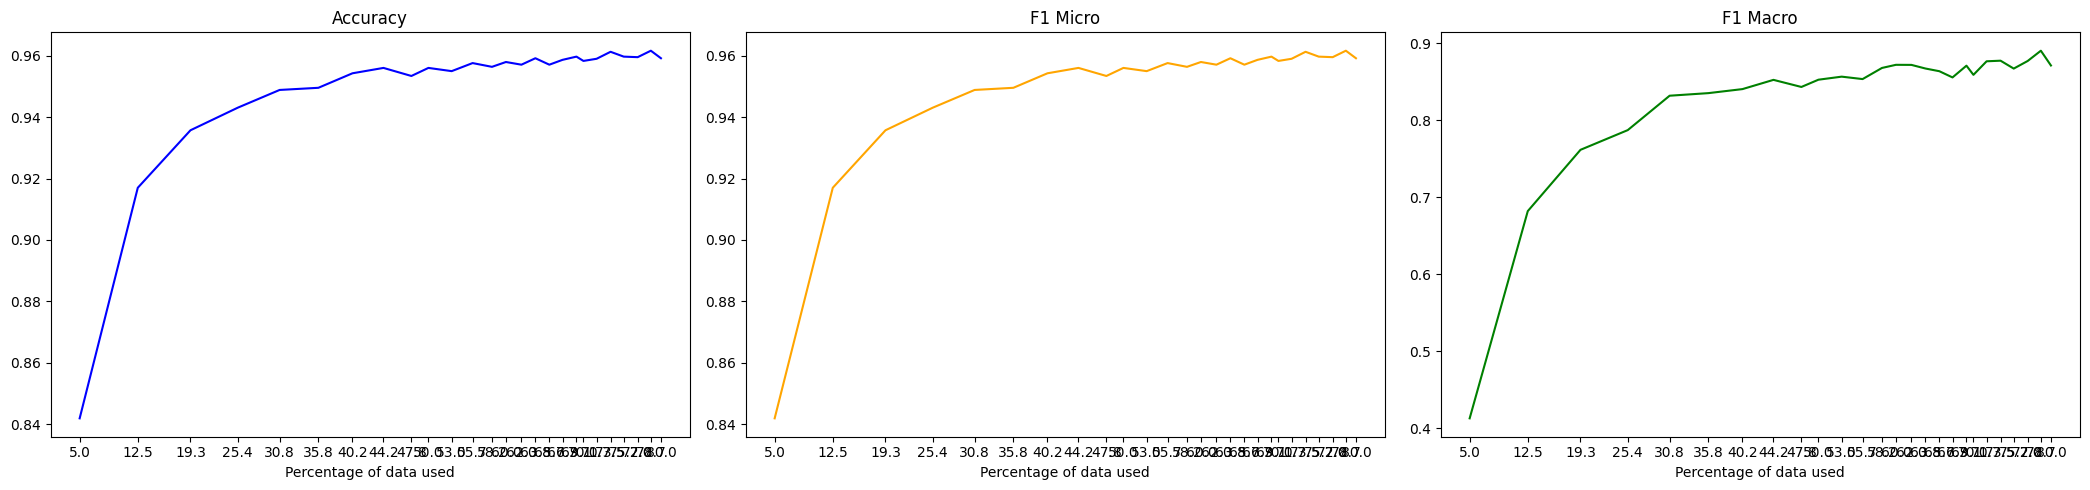

In [25]:
active_learning(seeds[0], 0)